In [1]:
import sys
sys.path.append("../")

import QuantLib as ql
import pandas as pd
from datetime import datetime, timedelta 
from pandas.tseries.offsets import CustomBusinessDay 
from pandas.tseries.holiday import USFederalHolidayCalendar

from CurvyCUSIPs.CurveInterpolator import GeneralCurveInterpolator
from CurvyCUSIPs.CurveDataFetcher import CurveDataFetcher
from CurvyCUSIPs.USTs import USTs
from CurvyCUSIPs.S490Swaps import S490Swaps
from CurvyCUSIPs.utils.regression_utils import run_multiple_linear_regression_df, run_basic_linear_regression_df

from CurvyCUSIPs.HedgeHog.beta import beta_estimates
from CurvyCUSIPs.HedgeHog.usts import dv01_neutral_curve_hedge_ratio, dv01_neutral_butterfly_hedge_ratio
import CurvyCUSIPs.HedgeHog.swaps as hh_swaps

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
config = dotenv_values(env_path)

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
plt.style.use('ggplot')
params = {'legend.fontsize': 'large',
        'figure.figsize': (15, 9),
        'axes.labelsize': 'large',
        'axes.titlesize':'large',
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'}
pylab.rcParams.update(params)

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

In [2]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True, fred_api_key=config["FRED_API_KEY"])

In [3]:
usts = USTs(
    cusip_set_db_path=r"..\db\ust_cusip_set",
    cusip_timeseries_db_path=r"..\db\ust_cusip_timeseries",
    ct_eod_db_path=r"..\db\ust_eod_ct_yields",
    curve_data_fetcher=curve_data_fetcher,
)

In [67]:
tenors = ["CT3M", "CT6M", "CT1", "CT2", "CT3", "CT5", "CT7", "CT10", "CT20", "CT30"]
bid_ct_yields_df = usts.fetch_ct_yields(start_date=datetime(2020, 1, 1), end_date=datetime(2024, 12, 20), use_offer_side=True)
offer_ct_yields_df = usts.fetch_ct_yields(start_date=datetime(2020, 1, 1), end_date=datetime(2024, 12, 20), use_bid_side=True)
bid_offer_spread_ct_yields_df: pd.DataFrame = bid_ct_yields_df - offer_ct_yields_df
display(bid_offer_spread_ct_yields_df)

eod_ct_yields_df: pd.DataFrame = usts.fetch_ct_yields(start_date=datetime(2020, 1, 1), end_date=datetime(2024, 12, 20)) 
eod_ct_yields_df

,CT3M,CT6M,CT1,CT2,CT3,CT5,CT7,CT10,CT20,CT30
Date,,,,,,,,,,
2020-01-02,-0.010190,0.000000,-0.005155,0.000000,0.000000,0.000000,0.000000,-0.001753,NaN,-0.001453
2020-01-03,-0.005211,-0.010323,-0.005197,-0.008016,0.000000,0.000000,-0.002381,-0.001742,NaN,-0.000714
2020-01-06,-0.010192,-0.015315,-0.005168,0.000000,0.000000,-0.003266,0.000000,0.000000,NaN,-0.000715
2020-01-07,-0.005093,-0.010207,-0.005166,0.000000,0.000000,0.000000,0.000000,-0.001745,NaN,-0.000718
2020-01-08,-0.010434,-0.015490,-0.005196,0.000000,0.000000,-0.003269,0.000000,0.000000,NaN,-0.000715
...,...,...,...,...,...,...,...,...,...,...
2024-12-16,-0.005162,-0.005243,-0.005433,0.000000,-0.005767,0.000000,0.000000,-0.001977,-0.001225,-0.000984
2024-12-17,-0.005161,-0.005240,-0.005430,0.000000,0.000000,-0.003544,0.000000,-0.001974,-0.001216,-0.000974
2024-12-18,-0.005164,-0.005240,-0.005428,0.000000,0.000000,0.000000,-0.002644,0.000000,-0.001221,-0.000976


,CT3M,CT6M,CT1,CT2,CT3,CT5,CT7,CT10,CT20,CT30
Date,,,,,,,,,,
2020-01-02,1.495137,1.541399,1.500667,1.576951,1.592126,1.664825,1.788178,1.875370,NaN,2.332653
2020-01-03,1.495383,1.521358,1.533151,1.528572,1.537487,1.592809,1.711830,1.791598,NaN,2.257948
2020-01-06,1.515466,1.531444,1.522778,1.544484,1.559215,1.605771,1.721337,1.805537,NaN,2.279333
2020-01-07,1.505333,1.521230,1.512409,1.544358,1.559146,1.618755,1.735629,1.826487,NaN,2.305162
2020-01-08,1.551548,1.548947,1.531309,1.544232,1.559078,1.605604,1.721305,1.805560,NaN,2.279317
...,...,...,...,...,...,...,...,...,...,...
2024-12-16,4.273180,4.267709,4.224859,4.248217,4.226354,4.244316,4.318720,4.390361,4.675722,4.602047
2024-12-17,4.282876,4.267204,4.235190,4.248107,4.224416,4.258507,4.324040,4.395133,4.673271,4.586854
2024-12-18,4.272166,4.256278,4.278011,4.349364,4.348871,4.393786,4.451621,4.494405,4.754284,4.649719


In [73]:
date = datetime(2021, 5, 14)
curve_set_df: pd.DataFrame = usts.fetch_historical_curve_sets(start_date=date, calc_free_float=True)[date]

otr_df: pd.DataFrame = curve_set_df[curve_set_df["rank"] == 0].sort_values(by="time_to_maturity")

curve_set_filtered_df = curve_set_df[
    (curve_set_df["rank"] != 0)
    & (curve_set_df["rank"] != 1)
    & (curve_set_df["rank"] != 2)
    & (curve_set_df["rank"] != 3)
]
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["security_type"] != "Bill"
]
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["free_float"] > 5000
]
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["time_to_maturity"] > 30 / 360
]
curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])

quote_type = "eod"
filtered_fitted_interpolator = GeneralCurveInterpolator(
    x=curve_set_filtered_df["time_to_maturity"].to_numpy(),
    y=curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)
fitted_bspline = filtered_fitted_interpolator.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
    k=3,
    return_func=True,
)

AGGREGATING CURVE SET DFs: 100%|██████████| 1/1 [00:00<00:00, 21.15it/s]


In [ ]:
nov30s_cusips = usts.ust_label_to_cusip("0.875% Nov-30")
nov40s_cusips = usts.ust_label_to_cusip("1.375% Nov-40")
nov50s_cusips = usts.ust_label_to_cusip("1.625% Nov-50")

cusips_timeseries_df = usts.get_ust_timeseries_by_cusips(
    start_date=datetime(2021, 1, 29), end_date=datetime(2021, 5, 14), cusips=[nov30s_cusips["cusip"], nov40s_cusips["cusip"], nov50s_cusips["cusip"]]
)
display(cusips_timeseries_df)
d, r = run_multiple_linear_regression_df(
    df=cusips_timeseries_df.reset_index(),
    x_cols=[f"{nov30s_cusips["cusip"]}-eod_yield", f"{nov50s_cusips["cusip"]}-eod_yield"],
    y_col=f"{nov40s_cusips["cusip"]}-eod_yield",
    on_diff=True,
)
print(r.summary())

,Date,91282CAV3-eod_yield,91282CAV3-eod_price,912810ST6-eod_yield,912810ST6-eod_price,912810SS8-eod_yield,912810SS8-eod_price
0,2021-01-29,1.050174,98.3750,1.623271,95.8125,1.813004,95.6875
1,2021-01-29,1.050174,98.3750,1.623271,95.8125,1.813004,95.6875
2,2021-01-29,1.050174,98.3750,1.623271,95.8125,1.813004,95.6875
3,2021-01-29,1.050174,98.3750,1.623271,95.8125,1.813004,95.6875
4,2021-01-29,1.050174,98.3750,1.623271,95.8125,1.813004,95.6875
...,...,...,...,...,...,...,...
595,2021-05-14,1.668101,93.0625,2.293629,85.6250,2.413126,83.4375
596,2021-05-14,1.668101,93.0625,2.293629,85.6250,2.413126,83.4375
597,2021-05-14,1.668101,93.0625,2.293629,85.6250,2.413126,83.4375
598,2021-05-14,1.668101,93.0625,2.293629,85.6250,2.413126,83.4375


                             OLS Regression Results                            
Dep. Variable:     912810ST6-eod_yield   R-squared:                       0.947
Model:                             OLS   Adj. R-squared:                  0.947
Method:                  Least Squares   F-statistic:                     5331.
Date:                 Sun, 05 Jan 2025   Prob (F-statistic):               0.00
Time:                         15:28:34   Log-Likelihood:                 2452.5
No. Observations:                  599   AIC:                            -4899.
Df Residuals:                      596   BIC:                            -4886.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.4

In [90]:
front_row = curve_set_df[curve_set_df["cusip"] == nov30s_cusips["cusip"]]
belly_row = curve_set_df[curve_set_df["cusip"] == nov40s_cusips["cusip"]]
back_row = curve_set_df[curve_set_df["cusip"] == nov50s_cusips["cusip"]]

# curve_pca_results = calc_pca_loadings_matrix(
#     df=eod_ct_yields_df, 
#     cols=["CT2", "CT10"], 
#     run_on_level_changes=True,
#     scale_loadings=True 
# )
# display(curve_pca_results)

# curve_beta_estimates_results = beta_estimates(
#     df=eod_ct_yields_df.reset_index(),
#     x_cols=["CT2"],
#     y_col="CT10",
#     run_on_level_changes=True,
#     # loadings_df=curve_pca_results["loading_matrix"],
#     # x_errs=bid_offer_spread_ct_yields_df["CT2"].to_numpy(),
#     # y_errs=bid_offer_spread_ct_yields_df["CT10"].to_numpy(),
# )

# curve_beta_estimates_results["betas"]

fly_hr_info_dict = dv01_neutral_butterfly_hedge_ratio(
    usts_obj=usts,
    as_of_date=date,
    front_wing_bond_row=front_row,
    belly_bond_row=belly_row,
    back_wing_bond_row=back_row,
    scipy_interp_curve=fitted_bspline,
    yvx_front_wing_beta_adjustment=0.465,
    yvx_back_wing_beta_adjustment=0.669,
    belly_par_amount=100_000_000,
)
fly_hr_info_dict

0.875% Nov-30 - 1.375% Nov-40 - 1.625% Nov-50 Fly
BPV Neutral Hedge Ratio:
{
    "front_wing_hr": 0.8516828274763505,
    "belly_hr": 1,
    "back_wing_hr": 0.38025796765483827
}
Beta Weighted Hedge Ratio:
{
    "front_wing_hr": 0.792065029553006,
    "belly_hr": 1,
    "back_wing_hr": 0.5087851607221736
}
Front Wing: 0.875% Nov-30 (OST 10-Year, TTM = 9.512329) Par Amount = 79_206_502.9553006
Belly: 1.375% Nov-40 (OST 20-Year, TTM = 19.520548) Par Amount = 100_000_000
Back Wing: 1.625% Nov-50 (OST 30-Year, TTM = 29.526027) Par Amount = 50_878_516.07221736
Total Trade Par Amount: 230_085_019.02751797
Risk Weights - Front Wing: 46.500%, Back Wing: 66.900%, Sum: 113.400%


{'curr_spread': 50.603093516660834,
 'rough_3m_impl_fwd_spread': np.float64(46.90504710992438),
 'rough_6m_impl_fwd_spread': np.float64(46.429049594785354),
 'rough_12m_impl_fwd_spread': np.float64(45.33290636797833),
 'front_wing_metrics': {'Date': datetime.datetime(2021, 5, 14, 0, 0),
  'zspread': 45.49321420005525,
  'zspread_impl_clean_price': 93.06193056282272,
  'clean_price': 93.05981475207794,
  'dirty_price': 96.97137178949463,
  'accrued_amount': 0.0023972602739785742,
  'bps': -0.08412992341832037,
  'dv01_1mm': -841.2992341832038,
  'mac_duration': 9.118184828975792,
  'mod_duration': 9.04276363442948,
  'convexity': 88.39892081391413,
  'basis_point_value': -0.08412992341832037,
  'yield_value_basis_point': -1.1886319041704775e-05,
  'rough_carry': np.float64(1.6581005408380625),
  'rough_3m_rolldown': np.float64(-14.246027490935663),
  'rough_6m_rolldown': np.float64(-10.073415493454863),
  'rough_12m_rolldown': np.float64(-1.6052096694376905)},
 'belly_metrics': {'Date':

In [4]:
sofr_ois = S490Swaps(s490_curve_db_path=r"..\db\nyclose_sofr_ois", curve_data_fetcher=curve_data_fetcher)
start_date = datetime(2024, 1, 1)
end_date = datetime(2025, 1, 2)
bdates = pd.date_range(start=start_date, end=end_date, freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))

In [5]:
fwd_tenors = ["1M", "3M", "6M", "9M", "12M", "18M", "2Y", "3Y", "4Y", "5Y", "6Y", "7Y", "8Y", "9Y", "10Y"]
fwd_grid_dict, ql_curves = sofr_ois.s490_nyclose_fwd_curve_matrices(
    start_date=start_date,
    end_date=end_date,
    ql_piecewise_method="logLinearDiscount",
    fwd_tenors=fwd_tenors,
)

Building Implied Fwd Curves...: 100%|██████████| 252/252 [00:02<00:00, 98.94it/s] 


In [6]:
fwd_grid_dict[datetime(2024, 12, 20)]

,Tenor,Spot,1M Fwd,3M Fwd,6M Fwd,9M Fwd,12M Fwd,18M Fwd,2Y Fwd,3Y Fwd,4Y Fwd,5Y Fwd,6Y Fwd,7Y Fwd,8Y Fwd,9Y Fwd,10Y Fwd
0,1D,4.363344,4.368316,4.368316,4.368316,4.026709,4.255142,3.836225,4.227862,3.976285,3.988416,3.943110,4.039484,3.971534,4.029793,4.103488,4.037956
1,1W,4.363642,4.368316,4.368316,4.221776,4.189824,3.955744,4.115816,4.084030,3.976285,3.981943,3.984402,4.010357,4.013144,4.029793,4.103488,4.045951
2,2W,4.362704,4.368316,4.368316,4.106986,4.222478,3.895967,4.171824,4.030143,3.982351,3.962524,4.011939,3.990944,4.021468,4.066634,4.070717,4.069939
3,3W,4.361767,4.368316,4.368316,4.091690,4.234355,3.876049,4.190500,4.012188,3.984372,3.956053,4.021120,3.984473,4.024243,4.078917,4.059796,4.077936
4,1M,4.360518,4.368316,4.368316,4.070724,4.239898,3.863201,4.201707,4.000605,3.985677,3.951346,4.027797,3.980025,4.026033,4.086843,4.052750,4.083752
5,2M,4.348119,4.368316,4.368316,4.049075,4.247883,3.849498,4.215407,3.988251,3.987089,3.947494,4.033263,3.975916,4.027943,4.095425,4.045236,4.088513
6,3M,4.335755,4.368316,4.368316,4.041222,4.250116,3.845414,4.219333,3.984569,3.987483,3.946130,4.035199,3.974553,4.028512,4.097818,4.043052,4.090199
7,4M,4.317386,4.368316,4.293233,4.086537,4.151665,3.843136,4.221430,3.982515,3.987720,3.945356,4.036348,3.973761,4.028838,4.099224,4.041746,4.091155
8,5M,4.299095,4.368316,4.240920,4.120677,4.086041,3.841763,4.222767,3.981278,3.987865,3.944898,4.036930,3.973333,4.029036,4.100071,4.040954,4.091722
9,6M,4.280882,4.317287,4.202882,4.143923,4.047568,3.840820,4.223574,3.980427,3.987952,3.944603,4.037365,3.973027,4.029156,4.100668,4.040476,4.092086


BUILDING OIS SWAP TIMESERIES DF...: 100%|██████████| 82/82 [00:00<00:00, 1032.89it/s]


                            OLS Regression Results                            
Dep. Variable:             1M Fwd 10Y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     4250.
Date:                Mon, 06 Jan 2025   Prob (F-statistic):           4.16e-71
Time:                        07:38:24   Log-Likelihood:                 149.31
No. Observations:                  82   AIC:                            -294.6
Df Residuals:                      80   BIC:                            -289.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7931      0.068    -11.605      0.0

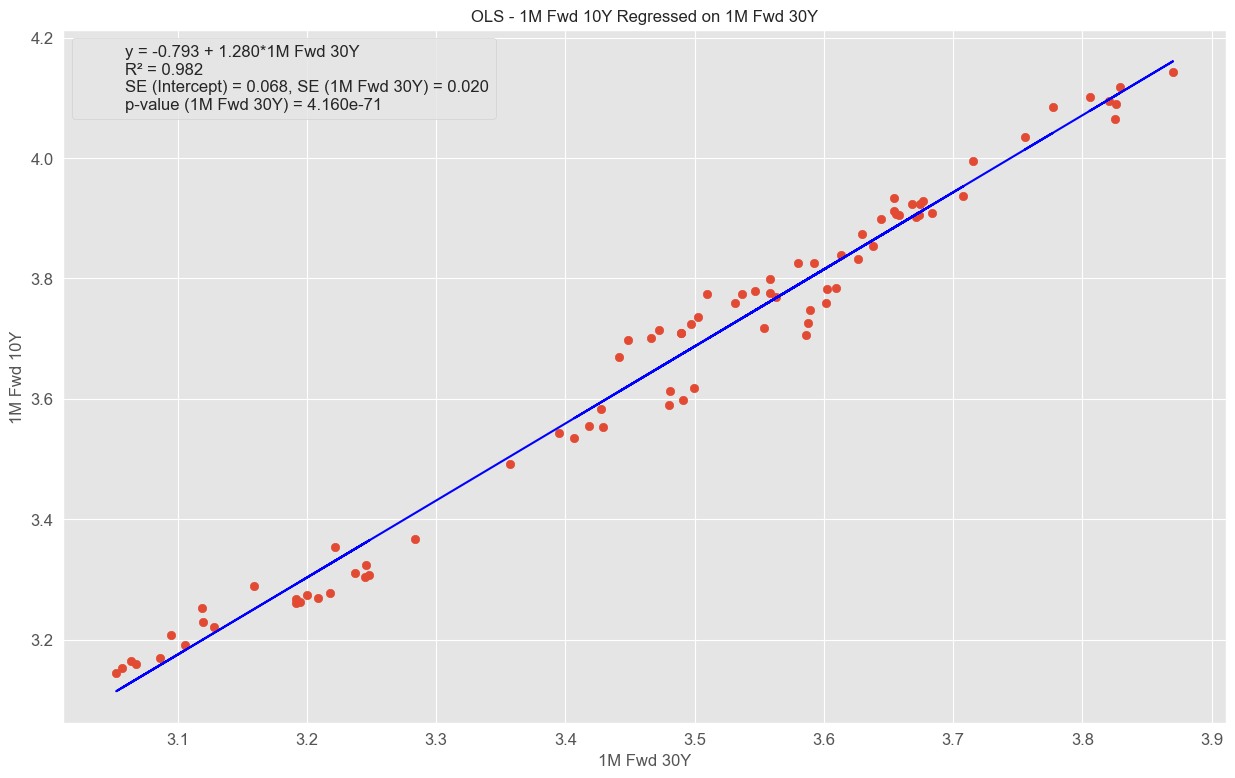

In [7]:
timeseries_temp_df = sofr_ois.timeseries_builder(
    fwd_dict_df=fwd_grid_dict,
    cols=["1M Fwd 10Y", "1M Fwd 30Y"],
    start_date=datetime(2024, 9, 1),
    end_date=datetime(2024, 12, 31),
    tenor_is_df_index=True,
    scale_curve=True,
)
timeseries_temp_df

run_basic_linear_regression_df(df=timeseries_temp_df, x_col="1M Fwd 30Y", y_col="1M Fwd 10Y")

In [19]:
date = datetime(2024, 12, 20)
hh_swaps.dv01_neutral_curve_hedge_ratio(
    front_leg_swap=hh_swaps.SwapLeg(
        original_tenor="1M Fwd 10Y", original_fixed_rate=4.035481/100, trade_date=date, weighting=1, 
    ),
    back_leg_swap=hh_swaps.SwapLeg(
        original_tenor="1M Fwd 30Y", original_fixed_rate=3.755582/100, trade_date=date, weighting=-1, 
    ),
    ql_curve=ql_curves[date],
    ql_yts=sofr_ois._ql_yts,
    ql_sofr=sofr_ois._ql_sofr,
    front_leg_notional=100_000_000,
    beta_adjustment_wrt_back_leg=1.2800,
)

BPV Neutral Hedge Ratio: -2.1336465599315804
Beta Weighted Hedge Ratio: -2.731068
1M Fwd 10Y: Notional = 100_000_000.000, PVBP = 81_495.592
1M Fwd 30Y: Notional = -36_615_717.648, PVBP = -63_668.431
Net Notional: 63_384_282.352
BVP Neutral PVBP: 81_495.592
Beta Weighted PVBP (bull steepening): 99_322.753


{'current_curve_bps': np.float64(-140.98336799999998),
 'current_curve_pvbp': np.float64(99322.75250800597),
 'bpv_neutral_curve_bps': np.float64(-27.989900000000013),
 'bpv_neutral_curve_pvbp': np.float64(81495.59180144077),
 '1M_carry_and_roll_bps_running': 0.36648878905899673,
 '1M_carry_and_roll_bps_running_beta_weighted': 0.1688701635870009,
 '2M_carry_and_roll_bps_running': 0.4839679500315275,
 '2M_carry_and_roll_bps_running_beta_weighted': 0.1537229255759165,
 '3M_carry_and_roll_bps_running': 0.6409862827341795,
 '3M_carry_and_roll_bps_running_beta_weighted': 0.20476248456980084,
 '6M_carry_and_roll_bps_running': 1.5625079068438963,
 '6M_carry_and_roll_bps_running_beta_weighted': 1.039409296498675,
 'total_trade_notional': 63384282.35156941,
 'front_leg': {'hr': -2.731067596712423,
  'bpv': -2.1336465599315804,
  'notional': 100000000,
  'pvbp_per_mm': 814.9559180144078,
  'pvbp_leg': 81495.59180144078,
  'bpv_bps_running': {'1M_carry': -0.8073907726220686,
   '1M_roll': 0.10160

In [63]:
timeseries_temp_df = sofr_ois.timeseries_builder(
    fwd_dict_df=fwd_grid_dict,
    cols=["6M Fwd 5Y", "6M Fwd 10Y", "6M Fwd 30Y"],
    start_date=datetime(2024, 9, 1),
    end_date=datetime(2024, 12, 31),
    tenor_is_df_index=True,
    scale_curve=True,
)
timeseries_temp_df

d, r = run_multiple_linear_regression_df(
    df=timeseries_temp_df, x_cols=["6M Fwd 5Y", "6M Fwd 30Y"], y_col="6M Fwd 10Y", show_plot=False, on_diff=True
)
print(r.summary())

BUILDING OIS SWAP TIMESERIES DF...: 100%|██████████| 82/82 [00:00<00:00, 858.10it/s]

                            OLS Regression Results                            
Dep. Variable:             6M Fwd 10Y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2545.
Date:                Sun, 05 Jan 2025   Prob (F-statistic):           9.31e-72
Time:                        15:10:56   Log-Likelihood:                 295.04
No. Observations:                  81   AIC:                            -584.1
Df Residuals:                      78   BIC:                            -576.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.142      0.8

In [124]:
date = datetime(2024, 12, 20)
bfly_hh = hh_swaps.dv01_neutral_butterfly_hedge_ratio(
    front_leg_swap=hh_swaps.SwapLeg(
        original_tenor="6M Fwd 5Y", original_fixed_rate=4.006766/100, trade_date=date, weighting=-0.5, 
    ),
    belly_swap=hh_swaps.SwapLeg(
        original_tenor="6M Fwd 10Y", original_fixed_rate=4.024217/100, trade_date=date, weighting=1, 
    ),
    back_leg_swap=hh_swaps.SwapLeg(
        original_tenor="6M Fwd 30Y", original_fixed_rate=3.729493/100, trade_date=date, weighting=-0.5, 
    ),
    ql_curve=ql_curves[date],
    ql_yts=sofr_ois._ql_yts,
    ql_sofr=sofr_ois._ql_sofr,
    belly_notional=100_000_000,
    front_wing_beta_adjustment_wrt_belly=0.5666,
    back_wing_beta_adjustment_wrt_belly=0.4901,
)


BPV Neutral Hedge Ratio:
{
    "front_wing_hr": -0.9097080301597273,
    "belly_hr": 1,
    "back_wing_hr": -0.23422451444311143
}
Beta Weighted Hedge Ratio:
{
    "front_wing_hr": -1.030881139777003,
    "belly_hr": 1,
    "back_wing_hr": -0.11252052452490324
}
6M Fwd 5Y: Fixed Notional = -103_088_113.978, PVBP = -45_431.795
6M Fwd 10Y: Fixed Notional = 100_000_000.000, PVBP = 80_183.189
6M Fwd 30Y: Fixed Notional = -11_252_052.452, PVBP = -19_259.842
Net Fixed Notional: -14_340_166.430
BPV Neutral Fly PVBP: -40_091.594
Beta Weighted Fly PVBP (naive): -45_002.285
Risk Weights - Front Wing: 56.660%, Back Wing: 49.010%, Sum: 105.670%
3M bps Running Carry & Roll: 2.579 bps
Beta Weigted 3M bps Running Carry & Roll: 2.514 bps


In [125]:
bfly_hh

{'current_fly_bps': np.float64(15.608749999999997),
 'current_fly_pvbp': np.float64(-45002.28502726166),
 'bpv_neutral_fly_bps': 15.608749999999997,
 'bpv_neutral_fly_pvbp': np.float64(-40091.59431024296),
 '1M_carry_and_roll_bps_running': 2.001798450593992,
 '1M_carry_and_roll_bps_running_beta_weigted': np.float64(1.979184209497626),
 '2M_carry_and_roll_bps_running': 2.263722936600848,
 '2M_carry_and_roll_bps_running_beta_weigted': np.float64(2.208393252239736),
 '3M_carry_and_roll_bps_running': 2.5792180533011635,
 '3M_carry_and_roll_bps_running_beta_weigted': np.float64(2.51382807349181),
 '6M_carry_and_roll_bps_running': 2.838672855025627,
 '6M_carry_and_roll_bps_running_beta_weigted': np.float64(2.7917450047300045),
 'total_trade_notional': np.float64(-14340166.430190632),
 'front_wing': {'hr': -1.030881139777003,
  'bpv_hr': -0.9097080301597273,
  'notional': np.float64(-103088113.97770031),
  'pvbp_per_mm': -440.7083699503416,
  'pvbp_leg': np.float64(45431.79467236732),
  'bpv_